source https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html

In [1]:
from __future__ import print_function
#%matplotlib inline
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

# Set random seem for reproducibility
manualSeed = 999
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

Random Seed:  999


### Inputs
* dataroot - the path to the root of the dataset folder. We will talk more about the dataset in the next section
* workers - the number of worker threads for loading the data with the DataLoader
* batch_size - the batch size used in training. The DCGAN paper uses a batch size of 128
* image_size - the spatial size of the images used for training. This implementation defaults to 64x64. If another size is desired, the structures of D and G must be changed. See here for more details
* nc - number of color channels in the input images. For color images this is 3
* nz - length of latent vector
* ngf - relates to the depth of feature maps carried through the generator
* ndf - sets the depth of feature maps propagated through the discriminator
* num_epochs - number of training epochs to run. Training for longer will probably lead to better results but will also take much longer
* lr - learning rate for training. As described in the DCGAN paper, this number should be 0.0002
* beta1 - beta1 hyperparameter for Adam optimizers. As described in paper, this number should be 0.5
* ngpu - number of GPUs available. If this is 0, code will run in CPU mode. If this number is greater than 0 it will run on that number of GPUs

In [2]:
# Root directory for dataset
dataroot = "data/celeba"
dataroot='/data/work/osa/2018-10-pytorch'# img_align_celeba
dataroot='/vanstee/2018-10-pytorch'# img_align_celeba
#dataroot='/gpfs/gpfs_gl4_16mb/s4s004/vanstee/2018-10-pytorch'# img_align_celeba

# Number of workers for dataloader
workers = 2

# Batch size during training
batch_size = 128

# Spatial size of training images. All images will be resized to this
#   size using a transformer.
image_size = 64

# Number of channels in the training images. For color images this is 3
nc = 3

# Size of z latent vector (i.e. size of generator input)
nz = 100

# Size of feature maps in generator
ngf = 64

# Size of feature maps in discriminator
ndf = 64

# Number of training epochs
num_epochs = 5

# Learning rate for optimizers
lr = 0.0002

# Beta1 hyperparam for Adam optimizers
beta1 = 0.5

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1

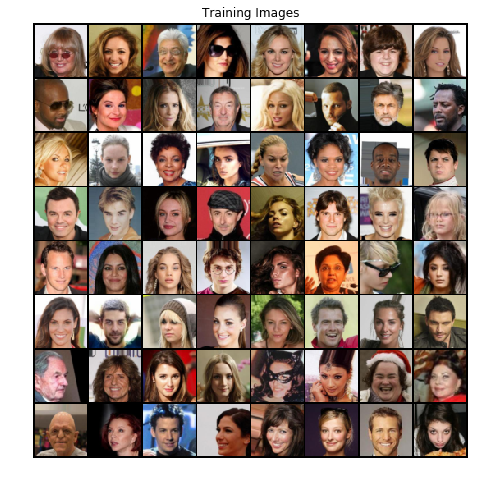

In [3]:
# We can use an image folder dataset the way we have it setup.
# Create the dataset
dataset = dset.ImageFolder(root=dataroot,
                           transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))
# Create the dataloader
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=workers)

# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

# Plot some training images
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

### Weight Initialization

In [4]:
# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

### Generator
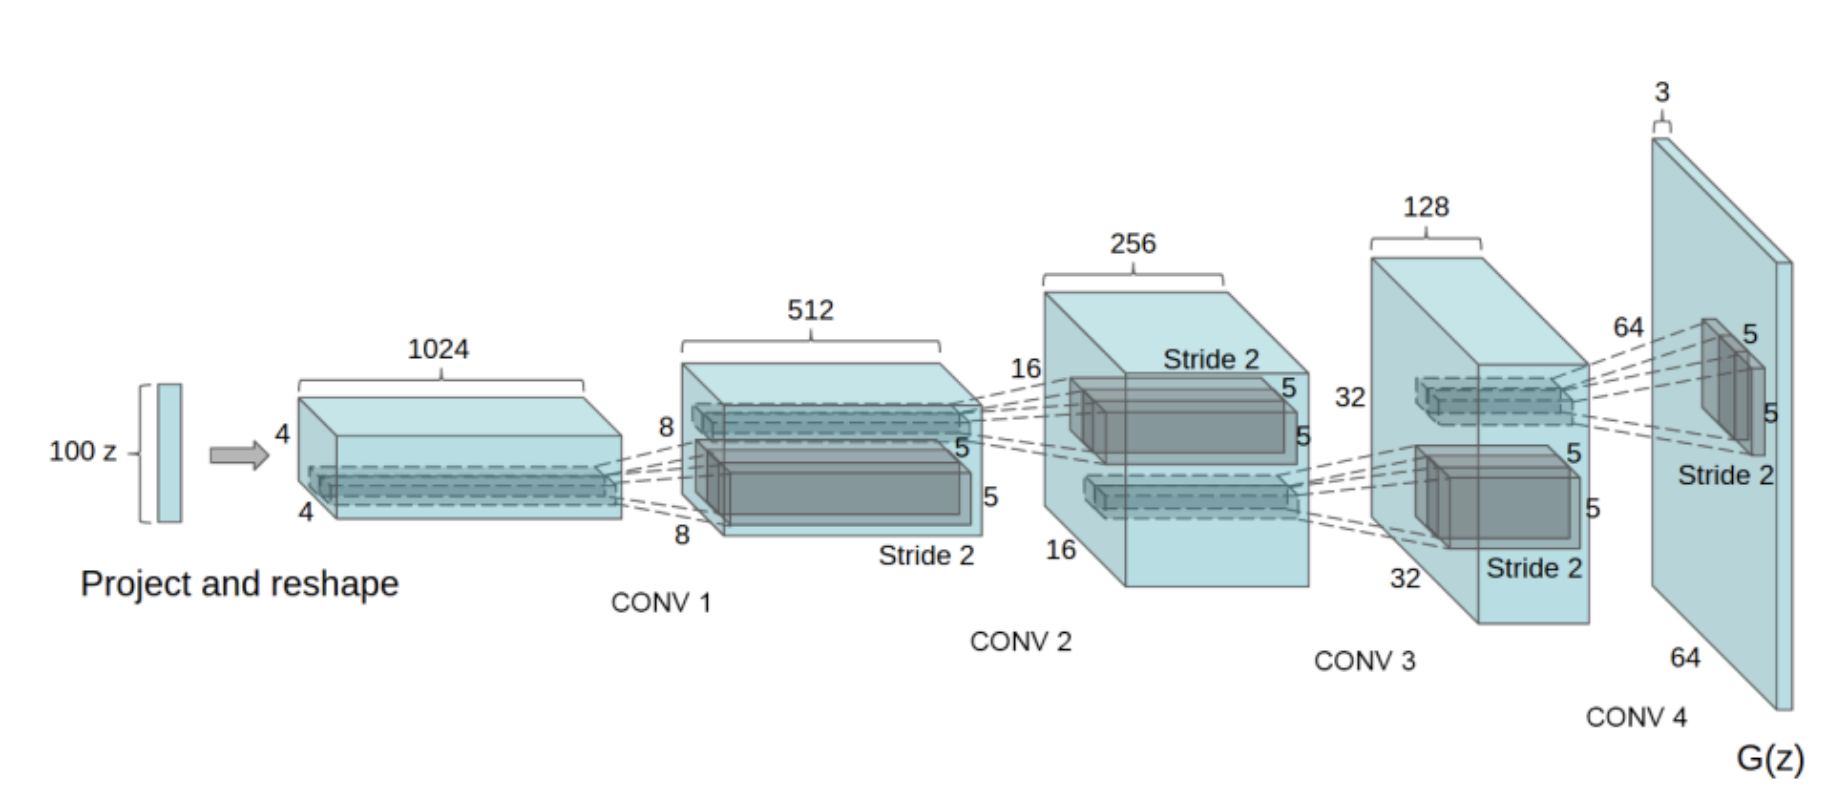

In [6]:
# Generator Code
# https://datascience.stackexchange.com/questions/6107/what-are-deconvolutional-layers
#torch.nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride=1, padding=0, output_padding=0, groups=1, bias=True, dilation=1)


# De-convolutions are essential the Convolution matrix transposed.  One way to think about this is to build a regular convo
# convolution matrix in the traditional sense.  Then take this operation and reverse it
# Iprime = C * I
# Ihat = C_transpose * Iprime !  


class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d( nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 32 x 32
            nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 64 x 64
        )

    def forward(self, input):
        return self.main(input)

In [7]:
ngpu

1

In [8]:
# Create the generator
netG = Generator(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netG = nn.DataParallel(netG, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netG.apply(weights_init)

# Print the model
print(netG)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)


### Discriminator

In [9]:
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is (nc) x 64 x 64
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 32 x 32
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 4 x 4
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

In [10]:
# Create the Discriminator
netD = Discriminator(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netD = nn.DataParallel(netD, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netD.apply(weights_init)

# Print the model
print(netD)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)


### Loss Functions and optimizers ..

In [11]:
# Initialize BCELoss function
criterion = nn.BCELoss()

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(64, nz, 1, 1, device=device)

# Establish convention for real and fake labels during training
real_label = 1
fake_label = 0

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

In [12]:
# Verify device type
device.type

'cuda'

In [13]:
conv2d_1 = nn.ConvTranspose2d( nz, ngf * 8, 4, 1, 0, bias=False).to(device)

for i, data in enumerate(dataloader, 0):

    real_cpu = data[0].to(device)
    print(real_cpu.size())
    b_size = real_cpu.size(0)   #128 
    noise = torch.randn(b_size, nz, 1, 1, device=device)
    print("noise NCHW = {}".format(noise.size()))
    output = conv2d_1(noise)
    print("output NCHW = {}".format(output.size()))

    break

torch.Size([128, 3, 64, 64])
noise NCHW = torch.Size([128, 100, 1, 1])
output NCHW = torch.Size([128, 512, 4, 4])


In [14]:
# Training Loop

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0

print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, data in enumerate(dataloader, 0):

        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        netD.zero_grad()
        # Format batch
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, device=device)
        # Forward pass real batch through D
        output = netD(real_cpu).view(-1)
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        # Generate fake image batch with G
        fake = netG(noise)
        label.fill_(fake_label)
        # Classify all fake batch with D
        output = netD(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Add the gradients from the all-real and all-fake batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()

        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters += 1

Starting Training Loop...
[0/5][0/1583]	Loss_D: 1.8320	Loss_G: 4.7774	D(x): 0.5144	D(G(z)): 0.5794 / 0.0124
[0/5][50/1583]	Loss_D: 0.0785	Loss_G: 33.6066	D(x): 0.9712	D(G(z)): 0.0000 / 0.0000
[0/5][100/1583]	Loss_D: 0.6999	Loss_G: 8.5566	D(x): 0.6899	D(G(z)): 0.0018 / 0.0026
[0/5][150/1583]	Loss_D: 1.9195	Loss_G: 2.5124	D(x): 0.3309	D(G(z)): 0.0148 / 0.1314
[0/5][200/1583]	Loss_D: 0.9433	Loss_G: 6.1667	D(x): 0.8913	D(G(z)): 0.4557 / 0.0053
[0/5][250/1583]	Loss_D: 0.5191	Loss_G: 6.6217	D(x): 0.8843	D(G(z)): 0.2862 / 0.0027
[0/5][300/1583]	Loss_D: 0.6024	Loss_G: 4.4692	D(x): 0.7888	D(G(z)): 0.2331 / 0.0276
[0/5][350/1583]	Loss_D: 0.4393	Loss_G: 4.5705	D(x): 0.8122	D(G(z)): 0.1427 / 0.0164
[0/5][400/1583]	Loss_D: 0.4083	Loss_G: 4.6419	D(x): 0.7893	D(G(z)): 0.0809 / 0.0206
[0/5][450/1583]	Loss_D: 0.7940	Loss_G: 2.8199	D(x): 0.6037	D(G(z)): 0.0267 / 0.1115
[0/5][500/1583]	Loss_D: 0.7959	Loss_G: 3.0352	D(x): 0.6819	D(G(z)): 0.2411 / 0.0756
[0/5][550/1583]	Loss_D: 0.4850	Loss_G: 4.4263	D(x): 

[3/5][50/1583]	Loss_D: 0.8452	Loss_G: 1.2733	D(x): 0.5267	D(G(z)): 0.0948 / 0.3462
[3/5][100/1583]	Loss_D: 0.9696	Loss_G: 1.3722	D(x): 0.4673	D(G(z)): 0.0778 / 0.3100
[3/5][150/1583]	Loss_D: 0.7437	Loss_G: 1.8758	D(x): 0.6473	D(G(z)): 0.1963 / 0.1860
[3/5][200/1583]	Loss_D: 0.4945	Loss_G: 2.4427	D(x): 0.7850	D(G(z)): 0.1998 / 0.1058
[3/5][250/1583]	Loss_D: 0.9703	Loss_G: 4.0434	D(x): 0.9324	D(G(z)): 0.5470 / 0.0242
[3/5][300/1583]	Loss_D: 0.5579	Loss_G: 1.9780	D(x): 0.7043	D(G(z)): 0.1364 / 0.1691
[3/5][350/1583]	Loss_D: 0.8120	Loss_G: 4.0198	D(x): 0.8946	D(G(z)): 0.4678 / 0.0232
[3/5][400/1583]	Loss_D: 1.0928	Loss_G: 1.2221	D(x): 0.4668	D(G(z)): 0.1617 / 0.3553
[3/5][450/1583]	Loss_D: 1.2255	Loss_G: 4.3061	D(x): 0.9350	D(G(z)): 0.6286 / 0.0210
[3/5][500/1583]	Loss_D: 0.8051	Loss_G: 2.9380	D(x): 0.8166	D(G(z)): 0.3969 / 0.0705
[3/5][550/1583]	Loss_D: 0.6236	Loss_G: 3.4245	D(x): 0.8523	D(G(z)): 0.3346 / 0.0440
[3/5][600/1583]	Loss_D: 0.9278	Loss_G: 3.7637	D(x): 0.9505	D(G(z)): 0.5284 / 

In [ ]:
img_list

In [ ]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()


In [ ]:
#%%capture
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())